# Isolation Forest
Isolation Forest is an ensemble, tree-based outlier detection algorithm that works on the principle that "outliers are few and different". Unlike density-based or distance-based methods, Isolation Forest isolates anomalies instead of profiling normal points.


Normal points: Require more partitions to isolate

Outliers: Require fewer partitions to isolate (easily separable)

How It Works - The Intuition
Imagine trying to isolate a single red apple in a basket of green apples:

Green apples (normal):

Randomly split the basket: green apples on both sides

Split again: still green apples on both sides

Need many splits to isolate any single green apple

Red apple (outlier):

Randomly split the basket: red apple separates immediately!

Only 1-2 splits needed to isolate the red apple

Mathematical Foundation
1. Random Partitioning
For a dataset with n points and d features:

Randomly select a feature

Randomly select a split value between min and max of that feature

Partition the data

2. Path Length (Isolation Score)
The number of edges (splits) required to isolate a point:


```h(x) = path length from root to leaf node ```
3. Average Path Length
For a binary tree with n nodes, the average path length:


``` c(n) = 2H(n-1) - 2(n-1)/n ```
Where H(i) is the harmonic number ≈ ln(i) + 0.5772156649

4. Anomaly Score

``` s(x, n) = 2^{-E[h(x)]/c(n)} ```
Where:

E[h(x)] = average path length across all trees

c(n) = normalization factor

Interpretation:

s ≈ 1: Definitely an anomaly

s ≈ 0.5: Normal point

s < 0.5: Definitely normal

### Step-by-Step Example
``` bash
Dataset: [10, 12, 14, 16, 18, 20, 1000]
Outlier: 1000

Building one isolation tree:

Step 1: Randomly select feature (only one in 1D)
Feature: The only feature

Step 2: Randomly select split value between min(10) and max(1000)
Say we pick split = 500

Step 3: Partition

Left: [10, 12, 14, 16, 18, 20] (needs more splits)

Right: [1000] (ISOLATED in 1 split!)

Path lengths:

For 1000: path length = 1 (isolated immediately)

For 10: needs many more splits

After building many trees:

1000 has very short average path length → high anomaly score

10 has long average path length → low anomaly score
```


=== Example 1: Simple 2D Dataset ===
Total points: 586
Outliers detected: 30
Anomaly score range: [-0.249, 0.158]

=== Point Explanations ===

Point 580 (true outlier):
  Coordinates: [15. 15.]
  Anomaly score: 0.158
  Interpretation: Moderately isolated (potential outlier)
  Top contributing features:
    Feature: z-score=4.71, importance=0.519, contribution=2.441
    Feature: z-score=4.71, importance=0.481, contribution=2.266

Point 581 (true outlier):
  Coordinates: [-10.   8.]
  Anomaly score: 0.136
  Interpretation: Moderately isolated (potential outlier)
  Top contributing features:
    Feature: z-score=3.40, importance=0.481, contribution=1.638
    Feature: z-score=2.44, importance=0.519, contribution=1.268

Point 582 (true outlier):
  Coordinates: [  8. -12.]
  Anomaly score: 0.128
  Interpretation: Difficult to isolate (normal point)
  Top contributing features:
    Feature: z-score=4.02, importance=0.519, contribution=2.086
    Feature: z-score=2.44, importance=0.481, contrib

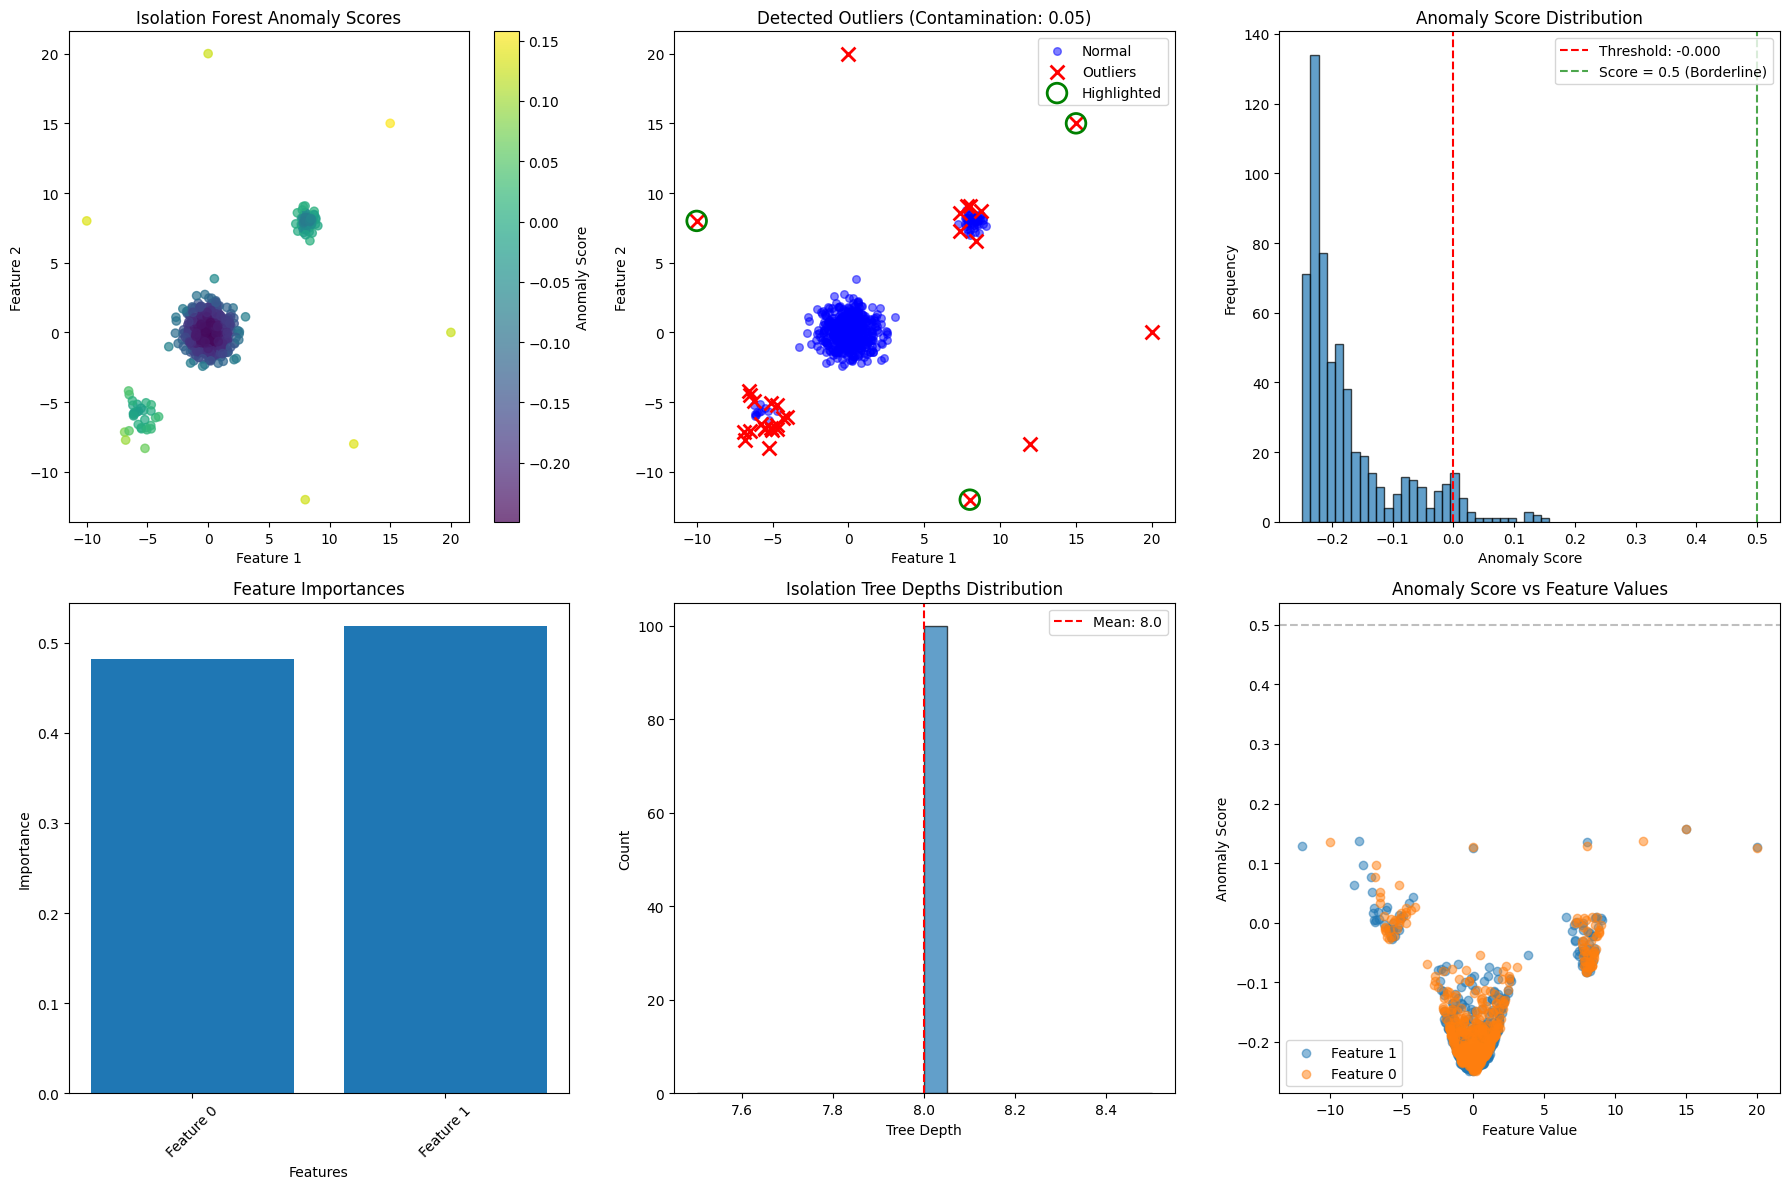


=== Example 2: Contamination Parameter Sensitivity ===
Contamination=0.01: Detected 6 outliers (1.0%), mean score=-0.274
Contamination=0.05: Detected 30 outliers (5.1%), mean score=-0.174
Contamination=0.1: Detected 59 outliers (10.1%), mean score=-0.128
Contamination=0.2: Detected 117 outliers (20.0%), mean score=-0.046
Contamination=0.3: Detected 176 outliers (30.0%), mean score=-0.001

=== Example 3: Manufacturing Quality Control ===

Manufacturing Defect Detection Results:
              precision    recall  f1-score   support

      Normal       0.03      0.00      0.00      1000
      Defect       0.00      0.00      0.00        30

    accuracy                           0.00      1030
   macro avg       0.02      0.00      0.00      1030
weighted avg       0.03      0.00      0.00      1030

Confusion Matrix:
[[  1 999]
 [ 30   0]]
Defect Detection Rate: 0/30 = 0.00%
False Alarm Rate: 999/1000 = 99.90%

Feature Importances for Defect Detection:
  Feature 0 (importance=0.247): Te

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs
import pandas as pd

class IsolationForestExplainer:
    """
    Comprehensive Isolation Forest implementation with explanations
    """
    
    def __init__(self, n_estimators=100, contamination=0.1, random_state=42):
        """
        Initialize Isolation Forest
        
        Parameters:
        -----------
        n_estimators : int, default=100
            Number of base estimators (trees) in the forest
        contamination : float or 'auto', default=0.1
            Expected proportion of outliers in the data
        random_state : int, default=42
            Random seed for reproducibility
        """
        self.n_estimators = n_estimators
        self.contamination = contamination
        self.random_state = random_state
        
        self.model = IsolationForest(
            n_estimators=n_estimators,
            contamination=contamination,
            random_state=random_state,
            verbose=0
        )
        
        self.feature_importances_ = None
        self.tree_depths_ = None
        
    def fit_predict(self, X, compute_importances=True):
        """
        Fit Isolation Forest and return predictions
        """
        X = np.array(X)
        self.X = X
        
        # Fit the model
        self.model.fit(X)
        
        # Get predictions and scores
        self.predictions = self.model.predict(X)  # 1 for normal, -1 for outliers
        self.scores = self.model.decision_function(X)  # Higher = more normal
        
        # Convert scores to anomaly scores (higher = more anomalous)
        self.anomaly_scores = -self.scores
        
        if compute_importances:
            self._compute_feature_importances()
            self._analyze_tree_depths()
        
        return self.predictions, self.anomaly_scores
    
    def _compute_feature_importances(self):
        """Compute feature importances based on split frequencies"""
        n_features = self.X.shape[1]
        feature_counts = np.zeros(n_features)
        total_splits = 0
        
        # Extract trees from the forest
        for tree in self.model.estimators_:
            tree_structure = tree.tree_
            features = tree_structure.feature
            
            # Count features used in splits (ignore leaf nodes: feature = -2)
            valid_features = features[features >= 0]
            unique_features, counts = np.unique(valid_features, return_counts=True)
            
            for feat, count in zip(unique_features, counts):
                feature_counts[feat] += count
                total_splits += count
        
        if total_splits > 0:
            self.feature_importances_ = feature_counts / total_splits
        else:
            self.feature_importances_ = np.ones(n_features) / n_features
        
        return self.feature_importances_
    
    def _analyze_tree_depths(self):
        """Analyze the depths of isolation trees"""
        depths = []
        for tree in self.model.estimators_:
            depths.append(tree.get_depth())
        
        self.tree_depths_ = {
            'mean': np.mean(depths),
            'std': np.std(depths),
            'min': np.min(depths),
            'max': np.max(depths),
            'all': depths
        }
        return self.tree_depths_
    
    def explain_point(self, point_index, n_trees_to_explain=5):
        """
        Explain why a point was flagged as outlier
        """
        if not hasattr(self, 'predictions'):
            raise ValueError("Must fit the model first")
        
        point = self.X[point_index]
        is_outlier = self.predictions[point_index] == -1
        anomaly_score = self.anomaly_scores[point_index]
        
        explanation = {
            'point': point,
            'is_outlier': is_outlier,
            'anomaly_score': anomaly_score,
            'normalized_score': (anomaly_score - np.min(self.anomaly_scores)) / 
                               (np.max(self.anomaly_scores) - np.min(self.anomaly_scores)),
            'feature_contributions': {},
            'tree_explanations': []
        }
        
        # Analyze feature contributions
        for i, (feature_val, importance) in enumerate(zip(point, self.feature_importances_)):
            # Calculate how extreme this feature value is
            feature_mean = np.mean(self.X[:, i])
            feature_std = np.std(self.X[:, i])
            z_score = abs(feature_val - feature_mean) / feature_std if feature_std > 0 else 0
            
            explanation['feature_contributions'][f'feature_{i}'] = {
                'value': feature_val,
                'importance': importance,
                'z_score': z_score,
                'contribution': importance * z_score
            }
        
        # Analyze specific trees
        for tree_idx, tree in enumerate(self.model.estimators_[:n_trees_to_explain]):
            path_length = self._get_path_length(tree, point)
            max_depth = tree.get_depth()
            
            tree_explanation = {
                'tree_index': tree_idx,
                'path_length': path_length,
                'max_depth': max_depth,
                'isolation_ease': 1 - (path_length / max_depth) if max_depth > 0 else 0
            }
            explanation['tree_explanations'].append(tree_explanation)
        
        # Overall interpretation
        avg_isolation_ease = np.mean([t['isolation_ease'] for t in explanation['tree_explanations']])
        
        if avg_isolation_ease > 0.7:
            explanation['interpretation'] = "Easily isolated across most trees (strong outlier)"
        elif avg_isolation_ease > 0.4:
            explanation['interpretation'] = "Moderately isolated (potential outlier)"
        else:
            explanation['interpretation'] = "Difficult to isolate (normal point)"
        
        return explanation
    
    def _get_path_length(self, tree, point):
        """Get path length for a point in a specific tree"""
        # Traverse the tree to find path length
        node = 0
        path_length = 0
        
        while tree.tree_.children_left[node] != -1:  # Not a leaf node
            feature = tree.tree_.feature[node]
            threshold = tree.tree_.threshold[node]
            
            if point[feature] <= threshold:
                node = tree.tree_.children_left[node]
            else:
                node = tree.tree_.children_right[node]
            
            path_length += 1
        
        # Adjust for leaf node size
        leaf_size = tree.tree_.n_node_samples[node]
        path_length += self._c(leaf_size)
        
        return path_length
    
    def _c(self, n):
        """Average path length of unsuccessful search in BST"""
        if n <= 1:
            return 0
        elif n == 2:
            return 1
        else:
            return 2 * (np.log(n - 1) + 0.5772156649) - 2 * (n - 1) / n
    
    def visualize(self, highlight_points=None):
        """
        Visualize Isolation Forest results
        """
        if not hasattr(self, 'predictions'):
            raise ValueError("Must fit the model first")
        
        n_features = self.X.shape[1]
        
        if n_features == 2:
            self._visualize_2d(highlight_points)
        elif n_features > 2:
            self._visualize_high_dim(highlight_points)
    
    def _visualize_2d(self, highlight_points=None):
        """Visualize 2D data"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Data points colored by anomaly score
        scatter1 = axes[0, 0].scatter(self.X[:, 0], self.X[:, 1], 
                                     c=self.anomaly_scores, 
                                     cmap='viridis', alpha=0.7)
        plt.colorbar(scatter1, ax=axes[0, 0], label='Anomaly Score')
        axes[0, 0].set_title('Isolation Forest Anomaly Scores')
        axes[0, 0].set_xlabel('Feature 1')
        axes[0, 0].set_ylabel('Feature 2')
        
        # Plot 2: Outliers highlighted
        normal_mask = self.predictions == 1
        outlier_mask = self.predictions == -1
        
        axes[0, 1].scatter(self.X[normal_mask, 0], self.X[normal_mask, 1],
                          c='blue', alpha=0.5, s=30, label='Normal')
        axes[0, 1].scatter(self.X[outlier_mask, 0], self.X[outlier_mask, 1],
                          c='red', s=100, marker='x', linewidth=2, label='Outliers')
        
        if highlight_points is not None:
            axes[0, 1].scatter(self.X[highlight_points, 0], self.X[highlight_points, 1],
                              facecolors='none', edgecolors='green', s=200,
                              linewidth=2, label='Highlighted')
        
        axes[0, 1].set_title(f'Detected Outliers (Contamination: {self.contamination})')
        axes[0, 1].set_xlabel('Feature 1')
        axes[0, 1].set_ylabel('Feature 2')
        axes[0, 1].legend()
        
        # Plot 3: Anomaly score distribution
        axes[0, 2].hist(self.anomaly_scores, bins=30, alpha=0.7, edgecolor='black')
        
        # Mark contamination threshold
        if self.contamination != 'auto':
            threshold = np.percentile(self.anomaly_scores, 100 * (1 - self.contamination))
            axes[0, 2].axvline(threshold, color='red', linestyle='--', 
                              label=f'Threshold: {threshold:.3f}')
        
        axes[0, 2].axvline(0.5, color='green', linestyle='--', 
                          label='Score = 0.5 (Borderline)', alpha=0.7)
        axes[0, 2].set_title('Anomaly Score Distribution')
        axes[0, 2].set_xlabel('Anomaly Score')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].legend()
        
        # Plot 4: Feature importances
        if self.feature_importances_ is not None:
            features = [f'Feature {i}' for i in range(len(self.feature_importances_))]
            axes[1, 0].bar(features, self.feature_importances_)
            axes[1, 0].set_title('Feature Importances')
            axes[1, 0].set_xlabel('Features')
            axes[1, 0].set_ylabel('Importance')
            axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Plot 5: Tree depths distribution
        if self.tree_depths_ is not None:
            axes[1, 1].hist(self.tree_depths_['all'], bins=20, alpha=0.7, edgecolor='black')
            axes[1, 1].axvline(self.tree_depths_['mean'], color='red', linestyle='--',
                              label=f'Mean: {self.tree_depths_["mean"]:.1f}')
            axes[1, 1].set_title('Isolation Tree Depths Distribution')
            axes[1, 1].set_xlabel('Tree Depth')
            axes[1, 1].set_ylabel('Count')
            axes[1, 1].legend()
        
        # Plot 6: Score vs feature value for top 2 features
        if len(self.feature_importances_) >= 2:
            top_features = np.argsort(self.feature_importances_)[-2:][::-1]
            
            for i, feat in enumerate(top_features):
                axes[1, 2].scatter(self.X[:, feat], self.anomaly_scores, 
                                  alpha=0.5, label=f'Feature {feat}')
            
            axes[1, 2].set_xlabel('Feature Value')
            axes[1, 2].set_ylabel('Anomaly Score')
            axes[1, 2].set_title('Anomaly Score vs Feature Values')
            axes[1, 2].legend()
            axes[1, 2].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
    
    def _visualize_high_dim(self, highlight_points=None):
        """Visualize high-dimensional data using PCA"""
        from sklearn.decomposition import PCA
        
        # Reduce to 2D for visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.X)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot 1: PCA visualization colored by anomaly score
        scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                                  c=self.anomaly_scores, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter1, ax=axes[0], label='Anomaly Score')
        axes[0].set_title('PCA Projection with Anomaly Scores')
        axes[0].set_xlabel('PCA Component 1')
        axes[0].set_ylabel('PCA Component 2')
        
        # Plot 2: Outliers in PCA space
        normal_mask = self.predictions == 1
        outlier_mask = self.predictions == -1
        
        axes[1].scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1],
                       c='blue', alpha=0.5, s=30, label='Normal')
        axes[1].scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1],
                       c='red', s=100, marker='x', linewidth=2, label='Outliers')
        
        if highlight_points is not None:
            axes[1].scatter(X_pca[highlight_points, 0], X_pca[highlight_points, 1],
                           facecolors='none', edgecolors='green', s=200,
                           linewidth=2, label='Highlighted')
        
        axes[1].set_title(f'Outliers in PCA Space')
        axes[1].set_xlabel('PCA Component 1')
        axes[1].set_ylabel('PCA Component 2')
        axes[1].legend()
        
        # Plot 3: Feature importances
        if self.feature_importances_ is not None:
            features = [f'F{i}' for i in range(len(self.feature_importances_))]
            axes[2].bar(features, self.feature_importances_)
            axes[2].set_title('Feature Importances in Isolation')
            axes[2].set_xlabel('Features')
            axes[2].set_ylabel('Importance')
            axes[2].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

# Example 1: Simple 2D dataset
print("=== Example 1: Simple 2D Dataset ===")
np.random.seed(42)

# Create main cluster
main_cluster = np.random.normal(0, 1, (500, 2))

# Create smaller clusters
cluster1 = np.random.normal(8, 0.5, (50, 2))
cluster2 = np.random.normal(-6, 0.8, (30, 2))

# Add isolated outliers
outliers = np.array([
    [15, 15],    # Far from everything
    [-10, 8],    # Far in negative x
    [8, -12],    # Far in negative y
    [12, -8],    # Far in diagonal
    [20, 0],     # Very far in x
    [0, 20]      # Very far in y
])

X = np.vstack([main_cluster, cluster1, cluster2, outliers])

# Apply Isolation Forest
iso_forest = IsolationForestExplainer(n_estimators=100, contamination=0.05, random_state=42)
predictions, scores = iso_forest.fit_predict(X)

print(f"Total points: {len(X)}")
print(f"Outliers detected: {np.sum(predictions == -1)}")
print(f"Anomaly score range: [{np.min(scores):.3f}, {np.max(scores):.3f}]")

# Explain specific points
print("\n=== Point Explanations ===")
for i in range(len(outliers)):
    point_idx = len(main_cluster) + len(cluster1) + len(cluster2) + i
    explanation = iso_forest.explain_point(point_idx, n_trees_to_explain=3)
    
    print(f"\nPoint {point_idx} (true outlier):")
    print(f"  Coordinates: {explanation['point']}")
    print(f"  Anomaly score: {explanation['anomaly_score']:.3f}")
    print(f"  Interpretation: {explanation['interpretation']}")
    
    # Show feature contributions for top 2 features
    contributions = list(explanation['feature_contributions'].values())
    contributions.sort(key=lambda x: x['contribution'], reverse=True)
    
    print("  Top contributing features:")
    for j, contrib in enumerate(contributions[:2]):
        print(f"    Feature: z-score={contrib['z_score']:.2f}, "
              f"importance={contrib['importance']:.3f}, "
              f"contribution={contrib['contribution']:.3f}")

# Visualize results
highlight_indices = [len(main_cluster) + len(cluster1) + len(cluster2) + i for i in range(3)]
iso_forest.visualize(highlight_points=highlight_indices)

# Example 2: Sensitivity to contamination parameter
print("\n=== Example 2: Contamination Parameter Sensitivity ===")

def analyze_contamination_sensitivity(X, contamination_values=[0.01, 0.05, 0.1, 0.2, 0.3]):
    """
    Analyze how contamination parameter affects results
    """
    results = []
    
    for contamination in contamination_values:
        iso_forest = IsolationForestExplainer(
            n_estimators=100, 
            contamination=contamination,
            random_state=42
        )
        predictions, scores = iso_forest.fit_predict(X, compute_importances=False)
        
        n_outliers = np.sum(predictions == -1)
        mean_score = np.mean(scores)
        
        results.append({
            'contamination': contamination,
            'n_outliers': n_outliers,
            'outlier_ratio': n_outliers / len(X),
            'mean_anomaly_score': mean_score,
            'score_std': np.std(scores)
        })
        
        print(f"Contamination={contamination}: "
              f"Detected {n_outliers} outliers ({n_outliers/len(X):.1%}), "
              f"mean score={mean_score:.3f}")
    
    return pd.DataFrame(results)

# Perform sensitivity analysis
contamination_results = analyze_contamination_sensitivity(X)

# Example 3: Real-world scenario - Manufacturing Defect Detection
print("\n=== Example 3: Manufacturing Quality Control ===")

def simulate_manufacturing_data(n_normal=1000, n_defective=30):
    """
    Simulate manufacturing sensor data
    Features: [temperature, pressure, vibration, production_speed]
    """
    np.random.seed(123)
    
    # Normal production measurements
    normal_products = np.column_stack([
        np.random.normal(100, 5, n_normal),           # Temperature
        np.random.normal(50, 3, n_normal),            # Pressure
        np.random.normal(20, 2, n_normal),            # Vibration
        np.random.normal(10, 1, n_normal),            # Production speed
    ])
    
    # Add correlations between features (real manufacturing processes have correlations)
    normal_products[:, 1] += 0.3 * normal_products[:, 0]  # Pressure depends on temperature
    normal_products[:, 2] += 0.1 * normal_products[:, 1]  # Vibration depends on pressure
    
    # Defective products (violate normal patterns)
    defective_products = np.column_stack([
        np.random.normal(120, 10, n_defective),       # Abnormal temperature
        np.random.normal(30, 10, n_defective),        # Abnormal pressure
        np.random.normal(40, 10, n_defective),        # Excessive vibration
        np.random.normal(15, 5, n_defective),         # Inconsistent speed
    ])
    
    # Remove correlations for defective products (they break patterns)
    # This makes them stand out to Isolation Forest
    
    # Combine data
    X_manufacturing = np.vstack([normal_products, defective_products])
    y_true = np.array([0] * n_normal + [1] * n_defective)
    
    return X_manufacturing, y_true

# Generate manufacturing data
X_mfg, y_true_mfg = simulate_manufacturing_data()

# Apply Isolation Forest for defect detection
iso_mfg = IsolationForestExplainer(
    n_estimators=200, 
    contamination=0.03,  # Expect ~3% defects
    random_state=42
)
y_pred_mfg, scores_mfg = iso_mfg.fit_predict(X_mfg)

# Convert predictions (1 for normal, -1 for defect)
y_pred_binary_mfg = (y_pred_mfg == 1).astype(int)

# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix

print("\nManufacturing Defect Detection Results:")
print(classification_report(y_true_mfg, y_pred_binary_mfg, 
                           target_names=['Normal', 'Defect']))

cm_mfg = confusion_matrix(y_true_mfg, y_pred_binary_mfg)
print(f"Confusion Matrix:\n{cm_mfg}")
print(f"Defect Detection Rate: {cm_mfg[1,1]}/{cm_mfg[1,:].sum()} = {cm_mfg[1,1]/cm_mfg[1,:].sum():.2%}")
print(f"False Alarm Rate: {cm_mfg[0,1]}/{cm_mfg[0,:].sum()} = {cm_mfg[0,1]/cm_mfg[0,:].sum():.2%}")

# Analyze feature importances
print("\nFeature Importances for Defect Detection:")
for i, importance in enumerate(iso_mfg.feature_importances_):
    print(f"  Feature {i} (importance={importance:.3f}): ", end="")
    if i == 0:
        print("Temperature")
    elif i == 1:
        print("Pressure")  
    elif i == 2:
        print("Vibration")
    elif i == 3:
        print("Production Speed")

# Advanced: Ensemble of Isolation Forests
class EnsembleIsolationForest:
    """
    Ensemble of Isolation Forests for robust anomaly detection
    """
    
    def __init__(self, n_forests=5, n_estimators=100, contamination_range=(0.01, 0.2)):
        self.n_forests = n_forests
        self.n_estimators = n_estimators
        self.contamination_range = contamination_range
        self.forests = []
        
    def fit_predict(self, X):
        """
        Fit multiple Isolation Forests and ensemble their predictions
        """
        X = np.array(X)
        self.X = X
        
        all_scores = []
        all_predictions = []
        
        # Train multiple forests with different parameters
        for i in range(self.n_forests):
            # Vary contamination parameter
            contamination = np.random.uniform(*self.contamination_range)
            
            # Create and fit forest
            iso_forest = IsolationForest(
                n_estimators=self.n_estimators,
                contamination=contamination,
                random_state=42 + i,
                max_samples=min(256, len(X))
            )
            
            iso_forest.fit(X)
            self.forests.append(iso_forest)
            
            # Get scores and predictions
            scores = -iso_forest.decision_function(X)  # Higher = more anomalous
            predictions = iso_forest.predict(X)
            
            all_scores.append(scores)
            all_predictions.append(predictions)
        
        # Ensemble scores (average)
        self.ensemble_scores = np.mean(all_scores, axis=0)
        
        # Ensemble predictions (voting)
        self.ensemble_predictions = np.sign(np.sum(all_predictions, axis=0))
        
        # For points with zero votes, use score-based decision
        zero_vote_mask = self.ensemble_predictions == 0
        if np.any(zero_vote_mask):
            median_score = np.median(self.ensemble_scores)
            self.ensemble_predictions[zero_vote_mask] = np.where(
                self.ensemble_scores[zero_vote_mask] > median_score, -1, 1
            )
        
        return self.ensemble_predictions, self.ensemble_scores
    
    def get_consistency(self):
        """
        Get consistency of predictions across forests
        """
        if not self.forests:
            raise ValueError("Must fit model first")
        
        n_points = len(self.X)
        consistency = np.zeros(n_points)
        
        for i in range(n_points):
            point_predictions = []
            for forest in self.forests:
                pred = forest.predict(self.X[i].reshape(1, -1))[0]
                point_predictions.append(pred)
            
            # Consistency = proportion of forests agreeing with ensemble
            agreement = np.sum(np.array(point_predictions) == self.ensemble_predictions[i])
            consistency[i] = agreement / len(self.forests)
        
        return consistency

# Example of ensemble approach
print("\n=== Ensemble Isolation Forest Example ===")
ensemble_iso = EnsembleIsolationForest(n_forests=5, n_estimators=50)
ensemble_preds, ensemble_scores = ensemble_iso.fit_predict(X)

print(f"Ensemble detected {np.sum(ensemble_preds == -1)} outliers")
print(f"Score range: [{np.min(ensemble_scores):.3f}, {np.max(ensemble_scores):.3f}]")

# Analyze consistency
consistency = ensemble_iso.get_consistency()
print(f"Average prediction consistency: {np.mean(consistency):.2%}")
print(f"Points with low consistency (<80%): {np.sum(consistency < 0.8)}")

tips = """
1. CHOOSING PARAMETERS:
   - n_estimators: 100-200 (more for complex data)
   - contamination: Use domain knowledge or try 'auto'
   - max_samples: 256 (good default) or 'auto'

2. FEATURE SCALING:
   - Isolation Forest doesn't require scaling (tree-based)
   - But scaling can help with interpretation

3. INTERPRETING SCORES:
   - Score close to 1: Strong anomaly
   - Score around 0.5: Borderline
   - Score close to 0: Normal point

4. ADVANTAGES:
   - Handles high-dimensional data well
   - Fast training and prediction
   - No distance or density calculations
   - Works with mixed data types

5. LIMITATIONS:
   - May miss clustered outliers
   - Less interpretable than some methods
   - Can be sensitive to contamination parameter

6. WHEN TO USE:
   - High-dimensional data
   - Large datasets
   - When speed is important
   - When outliers are truly "few and different"

7. VALIDATION:
   - Always validate with domain knowledge
   - Try different contamination values
   - Compare with other methods
   - Use ensemble for robustness
"""

print(tips)

# Comparative Analysis
def compare_with_other_methods(X, y_true=None):
    """
    Compare Isolation Forest with other outlier detection methods
    """
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.svm import OneClassSVM
    from sklearn.covariance import EllipticEnvelope
    
    results = {}
    
    # 1. Isolation Forest
    iso_forest = IsolationForest(contamination='auto', random_state=42)
    results['IsolationForest'] = -iso_forest.fit_predict(X)
    
    # 2. Local Outlier Factor
    lof = LocalOutlierFactor(contamination='auto', novelty=False)
    results['LOF'] = -lof.fit_predict(X)
    
    # 3. One-Class SVM
    oc_svm = OneClassSVM(gamma='auto', nu=0.1)
    results['OneClassSVM'] = -oc_svm.fit_predict(X)
    
    # 4. Elliptic Envelope (Mahalanobis distance)
    if y_true is not None:
        # Need to assume some contamination
        envelope = EllipticEnvelope(contamination=0.1, random_state=42)
        results['EllipticEnvelope'] = -envelope.fit_predict(X)
    
    # Analyze correlations between methods
    scores_df = pd.DataFrame(results)
    correlation_matrix = scores_df.corr()
    
    print("Correlation between outlier detection methods:")
    print(correlation_matrix)
    
    return results

# Compare methods
print("\n=== Method Comparison ===")
method_scores = compare_with_other_methods(X[:500])  # Use subset for speed

Isolation Forest is an ensemble tree-based algorithm that isolates anomalies instead of profiling normal points. It works on the principle that 'outliers are few and different,' meaning they can be isolated with fewer random partitions than normal points.

The algorithm builds multiple isolation trees by randomly selecting features and split values. Anomalies have short average path lengths in these trees, leading to high anomaly scores. The key advantages are its linear time complexity, ability to handle high-dimensional data without distance calculations, and robustness to irrelevant features.

It's particularly effective for high-dimensional datasets and situations where computational efficiency is important, like real-time fraud detection or network intrusion detection.

When to Use Isolation Forest
- Excellent for:

High-dimensional data (no curse of dimensionality)

Large datasets (linear time complexity)

Real-time applications (fast prediction)

Mixed data types (handles categorical and numerical)

When outliers are truly isolated

- Not ideal for:

Clustered outliers (may be treated as separate clusters)

Low-dimensional data with clear density patterns

When interpretability is critical

When you need probability estimates